In [1]:
from typing import Sequence, Dict
from collections import defaultdict, Counter
import random
import math
import numpy as np
import pandas as pd
from scipy import stats

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from sklearn.linear_model import LogisticRegression

from abc import ABC, abstractmethod
from IPython import display
import krippendorff
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

In [2]:
from util import DataHandler

In [3]:
def get_bin_idx(score, size=10):
    return min(int(score * size), size-1)

In [4]:
_SQRT2 = np.sqrt(2)

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [5]:
dark_gray_color = '#666666'
positive_color = '#3d85c6'
negative_color = '#cc0000'

# Load dataset

## dataset1

In [6]:
base_dh = DataHandler('data/dataset1_base.csv')
target_dh = DataHandler('data/dataset1_target.csv')

In [7]:
base_dh._p_gt

0.2

In [8]:
target_dh._p_gt

0.7

In [9]:
base_dh.observed_df

,UC(X),GT
0,0.413078,
1,0.043531,
2,0.783203,
3,0.445445,
4,0.420265,
...,...,...
9995,0.232804,
9996,0.125653,
9997,0.574881,
9998,0.777726,


In [10]:
base_dh.count_gt()

0

In [11]:
base_dh.get_oracle_labels(rows=[0,1,2])

In [12]:
base_dh.observed_df

,UC(X),GT
0,0.413078,False
1,0.043531,False
2,0.783203,True
3,0.445445,
4,0.420265,
...,...,...
9995,0.232804,
9996,0.125653,
9997,0.574881,
9998,0.777726,


In [13]:
base_dh.count_gt()

3

In [14]:
sampeld_rows = base_dh.get_sample_for_labeling(n_item=100, strategy='random')

In [15]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [16]:
base_dh.count_gt()

103

In [17]:
base_dh.observed_df

,UC(X),GT
0,0.413078,False
1,0.043531,False
2,0.783203,True
3,0.445445,
4,0.420265,
...,...,...
9995,0.232804,
9996,0.125653,
9997,0.574881,
9998,0.777726,


In [18]:
base_dh.load_features(features=['has_url', 'lang'])

In [19]:
base_dh.observed_df

,UC(X),GT,has_url,lang
0,0.413078,False,yes,es
1,0.043531,False,no,en
2,0.783203,True,yes,es
3,0.445445,,yes,en
4,0.420265,,no,es
...,...,...,...,...
9995,0.232804,,no,en
9996,0.125653,,no,es
9997,0.574881,,yes,es
9998,0.777726,,yes,es


# Let's first try some approaches

Given: classifier scores UC(X)

Target: P(GT=1)

## 1. Classify and Count (threshold = 0.5)

In [20]:
threshold = 0.5
est_p_cc = base_dh.observed_df[base_dh.observed_df['UC(X)'] > threshold].shape[0] / base_dh.size
est_p_cc

0.286

In [21]:
base_dh._p_gt

0.2

## 2. Probabilistic Estimator

In [22]:
est_p_pe = base_dh.observed_df['UC(X)'].sum() / base_dh.size
est_p_pe

0.39666988735203507

In [23]:
base_dh._p_gt

0.2

# 3. Now assume we have some budget to label some data

In [24]:
base_dh.count_gt()

103

In [25]:
base_dh.size

10000

In [26]:
# let's label 20% data
num_sample = int(0.7 * base_dh.size)

In [27]:
sampeld_rows = base_dh.get_sample_for_labeling(n_item=num_sample, strategy='random')

In [28]:
base_dh.get_oracle_labels(rows=sampeld_rows)

In [29]:
base_dh.count_gt()

7103

In [30]:
labeled_sample = base_dh.get_labeled_sample()

In [31]:
labeled_sample.shape

(7103, 4)

In [32]:
labeled_sample.loc[:, 'GT'] = labeled_sample['GT'].astype('bool')

/Users/siqiwu/Developments/env/anaconda3/envs/twitter-sampling/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [33]:
labeled_sample

,UC(X),GT,has_url,lang
0,0.413078,False,yes,es
1,0.043531,False,no,en
2,0.783203,True,yes,es
3,0.445445,False,yes,en
4,0.420265,False,no,es
...,...,...,...,...
9993,0.876254,True,no,es
9994,0.808262,True,no,es
9995,0.232804,False,no,en
9998,0.777726,True,yes,es


## 3.1 Learn the optimal threshold by F1

In [34]:
from sklearn.metrics import roc_auc_score, f1_score

In [35]:
labeled_sample['GT'].values

array([False, False,  True, ..., False,  True,  True])

In [36]:
labeled_sample['UC(X)'].values

array([0.41307831, 0.04353145, 0.78320298, ..., 0.23280438, 0.77772584,
       0.57928985])

In [37]:
roc_auc_score(labeled_sample['GT'].values, labeled_sample['UC(X)'].values)

0.9948730215634132

In [38]:
labeled_sample['UC(X)'].map(lambda x: True if x > 0.3 else False).values

array([ True, False,  True, ..., False,  True,  True])

In [39]:
best_threshold = 0
best_f1 = 0

for thres in np.linspace(0, 1, 101):
    f1 = f1_score(labeled_sample['GT'].values,
             labeled_sample['UC(X)'].map(lambda x: True if x >= thres else False).values)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thres

best_threshold, best_f1

(0.66, 0.9287486706841546)

## with the best threshold

In [40]:
est_p_cc = base_dh.observed_df[base_dh.observed_df['UC(X)'] >= best_threshold].shape[0] / base_dh.size
est_p_cc

0.2004

## 3.2 learn a platt scaling function

(array([ 619., 1337., 1306., 1053.,  776.,  417.,  287.,  333.,  506.,
         469.]),
 array([3.42969312e-04, 1.00110881e-01, 1.99878793e-01, 2.99646705e-01,
        3.99414617e-01, 4.99182529e-01, 5.98950441e-01, 6.98718353e-01,
        7.98486265e-01, 8.98254177e-01, 9.98022089e-01]),
 <BarContainer object of 10 artists>)

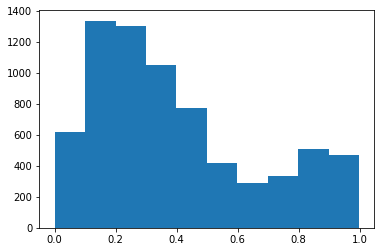

In [41]:
plt.hist(labeled_sample['UC(X)'].values)

In [42]:
from sklearn.linear_model import LogisticRegression

In [43]:
train_UCX = labeled_sample['UC(X)'].values.reshape(-1, 1)
train_GT = labeled_sample['GT'].values
prob_cali_func = LogisticRegression(fit_intercept=True).fit(train_UCX, train_GT)

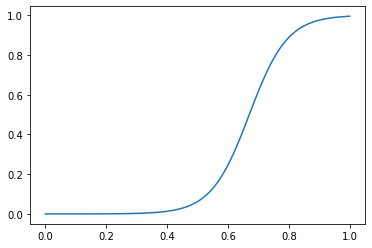

In [44]:
empir_cx_axis = np.linspace(0, 1, 101)
prob_cali_curve = prob_cali_func.predict_proba(empir_cx_axis.reshape(-1, 1))[:, -1]

plt.plot(empir_cx_axis, prob_cali_curve)

In [45]:
cali_prob_scores = prob_cali_func.predict_proba(base_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]

In [46]:
cali_prob_scores.sum() / len(cali_prob_scores)

0.19888288077040758

## 3.3 learn the class-conditional density function

(array([ 618., 1338., 1309., 1052.,  776.,  418.,  290.,  329.,  519.,
         454.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

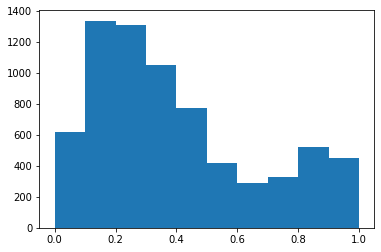

In [47]:
plt.hist(labeled_sample['UC(X)'].values, bins=np.linspace(0, 1, 11))

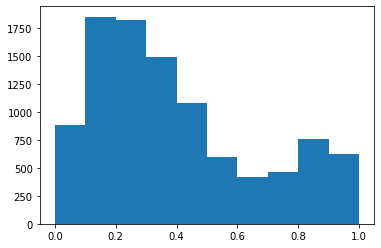

In [48]:
obs_freq, _, _ = plt.hist(base_dh.observed_df['UC(X)'].values, bins=np.linspace(0, 1, 11))

In [49]:
obs_freq /= obs_freq.sum()

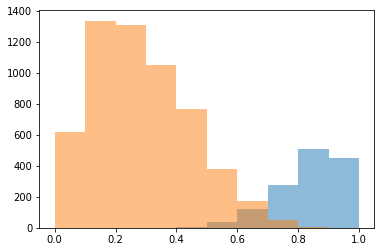

In [50]:
pos_freq, _, _ = plt.hist(labeled_sample[labeled_sample['GT'] == True]['UC(X)'].values, bins=np.linspace(0, 1, 11), alpha=0.5)
neg_freq, _, _ = plt.hist(labeled_sample[labeled_sample['GT'] == False]['UC(X)'].values, bins=np.linspace(0, 1, 11), alpha=0.5)

In [51]:
pos_freq /= pos_freq.sum()
neg_freq /= neg_freq.sum()

In [52]:
_SQRT2 = np.sqrt(2)

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [53]:
min_dist = 100
best_p_p = 0

for p_p in np.linspace(0, 1, 101):
    dist = hellinger(obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
    if dist < min_dist:
        min_dist = dist
        best_p_p = p_p

In [54]:
best_p_p, min_dist

(0.2, 0.0059410975257427725)

# 4. estimate for the target period

## 4.1 PCC

In [55]:
target_cali_prob_scores = prob_cali_func.predict_proba(target_dh.observed_df['UC(X)'].values.reshape(-1, 1))[:, -1]

In [56]:
target_cali_prob_scores.sum() / len(target_cali_prob_scores)

0.6124480421596635

## 4.2 MM

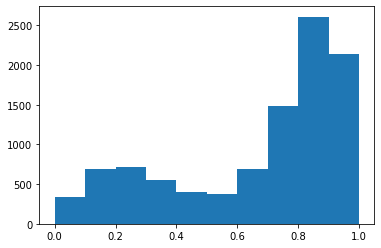

In [57]:
target_obs_freq, _, _ = plt.hist(target_dh.observed_df['UC(X)'].values, bins=np.linspace(0, 1, 11))

In [58]:
min_dist = 10000
best_p_p = 0

for p_p in np.linspace(0, 1, 101):
    dist = hellinger(target_obs_freq, pos_freq * p_p + neg_freq * (1 - p_p))
    if dist < min_dist:
        min_dist = dist
        best_p_p = p_p

In [59]:
best_p_p, min_dist

(0.7000000000000001, 70.00372587974367)